<a href="https://colab.research.google.com/github/ritamgh/DLT-lab/blob/main/Week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files

# Upload kaggle.json (get it from your Kaggle account settings)
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.16GB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [ ]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None)
df.columns = ["target","id","date","flag","user","text"]

# target: 0 = negative, 4 = positive → convert 4 → 1
df["target"] = df["target"].replace(4,1)

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (1600000, 6)
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


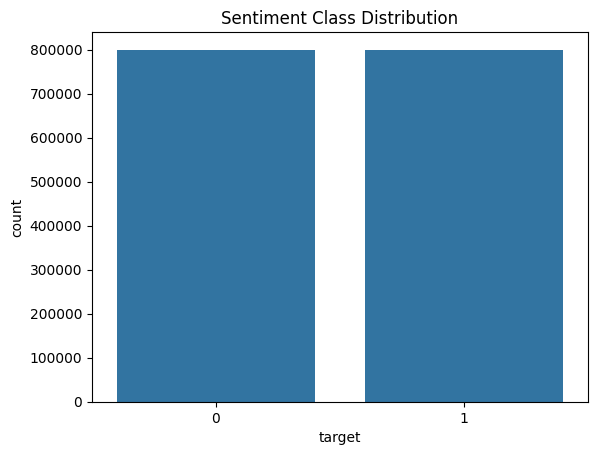

In [ ]:
sns.countplot(x=df["target"])
plt.title("Sentiment Class Distribution")
plt.show()


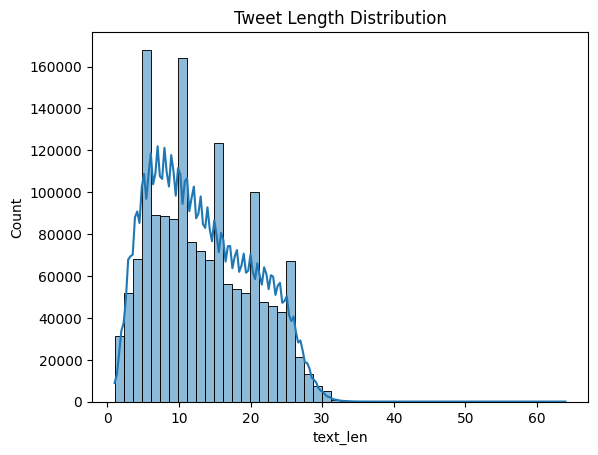

In [ ]:
df["text_len"] = df["text"].apply(lambda x: len(x.split()))
sns.histplot(df["text_len"], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.show()

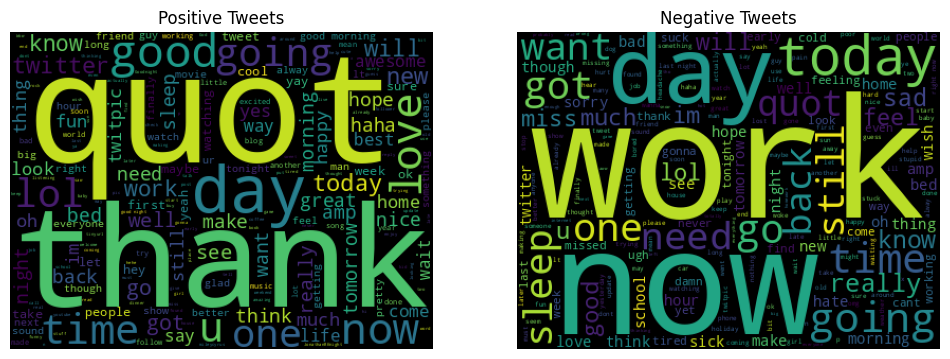

In [ ]:
pos_text = " ".join(df[df.target==1]["text"][:5000])
neg_text = " ".join(df[df.target==0]["text"][:5000])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400,height=300).generate(pos_text))
plt.axis("off")
plt.title("Positive Tweets")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400,height=300).generate(neg_text))
plt.axis("off")
plt.title("Negative Tweets")
plt.show()

In [ ]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+","",s)
    s = re.sub(r"@\w+","",s)
    s = re.sub(r"[^a-z0-9\s]","",s)
    s = re.sub(r"\s+"," ",s).strip()
    return s

df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["target"], random_state=42)

In [ ]:
MAX_VOCAB = 20000
MAX_LEN = 40

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df["clean_text"]), maxlen=MAX_LEN)
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_df["clean_text"]), maxlen=MAX_LEN)

y_train = train_df["target"].values
y_test  = test_df["target"].values

In [ ]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=512,
    validation_split=0.2
)

Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 465s 231ms/step - accuracy: 0.7716 - loss: 0.4737 - val_accuracy: 0.8158 - val_loss: 0.4015
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 502s 231ms/step - accuracy: 0.8244 - loss: 0.3888 - val_accuracy: 0.8202 - val_loss: 0.3938
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 460s 230ms/step - accuracy: 0.8356 - loss: 0.3668 - val_accuracy: 0.8211 - val_loss: 0.3940
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 492s 225ms/step - accuracy: 0.8454 - loss: 0.3481 - val_accuracy: 0.8202 - val_loss: 0.3991
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 458s 229ms/step - accuracy: 0.8543 - loss: 0.3300 - val_accuracy: 0.8194 - val_loss: 0.4092


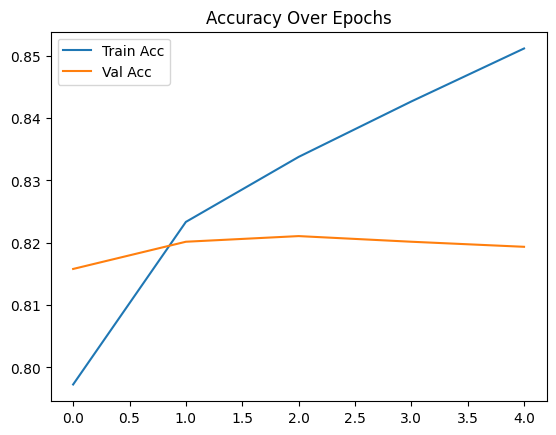

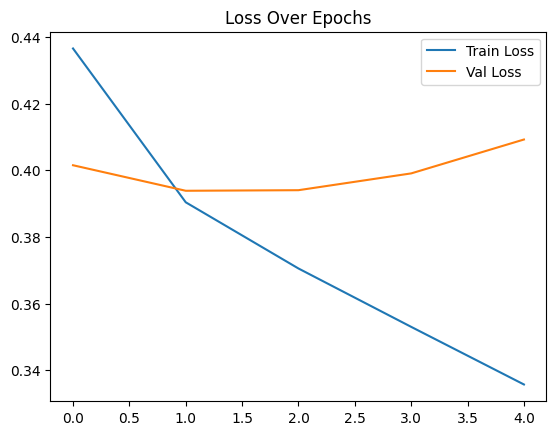

In [ ]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test, batch_size=1024)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    160000
           1       0.81      0.83      0.82    160000

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

ROC-AUC: 0.898757369921875


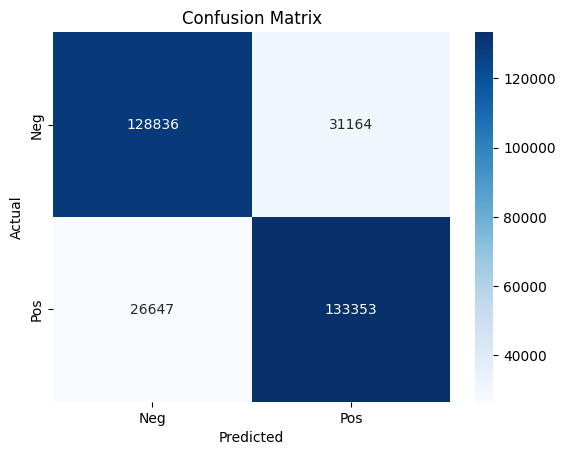

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()